#Вводная информация

Для выполнения тестового задания вам потребуется скачать несколько csv файлов –
представьте, что это таблицы базы данных (преобразуйте их в pd.DataFrame перед
началом работы).

Таблицы содержат данные по пользователям, привлеченным в Hero Wars в некотором
промежутке времени. В течение этого периода были активны несколько рекламных
кампаний, которые могли отличаться настройками и сетапом запуска. Длительность
рекламных кампаний варьировалась, каждый запуск был непрерывным.

Все расчеты по задачам необходимо выполнить в Jupyter Notebook на языке Python и
выслать контактному лицу. Большая просьба ставить заголовки, например “Задача 1”, чтобы можно было ориентироваться в ноутбуке при проверке. Текстовые выводы и
SQL запросы можно также оставить в ноутбуке под соответствующим заголовком.

# 0. Подготовка данных

In [1]:
# Библиотеки
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

from google.colab import drive
drive.mount('/content/drive')

# Стили графиков
sns.set_palette('pastel')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

Mounted at /content/drive


In [2]:
registration = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Nexters/registration.csv")
payment = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Nexters/payment.csv")
tutorial =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Nexters/tutorial.csv")
ad_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Nexters/ad_data.csv")

for df in [registration, payment, ad_data]:
    df['date'] = pd.to_datetime(df['date'])

reference_date = pd.Timestamp('1970-01-01')
registration['reg_ts'] = registration['ts'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))
tutorial['tut_ts'] = tutorial['ts'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))
payment['pay_ts'] = payment['ts'].apply(lambda x: reference_date + pd.to_timedelta(x, unit='s'))

ad_data = ad_data.rename(columns={'capmaign': 'campaign'})

#Задача 1: Расчет эффективности рекламных кампаний

Определите, какую эффективность показали рекламные кампании от A до H в период
их активности. Критерий эффективности рекламной кампании: Если привлечение 1
пользователя, который становится плательщиком 7 дня, обходится нам в 50$ или
дешевле, значит кампания эффективна.

Плательщик 7 дня – это пользователь, который совершил хотя бы 1 покупку в течение 7 первых дней жизни (в первые 0-168 часов жизни) после регистрации.

## Алгоритм скрипта


1. Объединение данных о регистрации и платежах пользователей для анализа lifetime пользователя с момента регистрации до момента платежа. Расчет lifetime пользователя для каждого платежа.
2. Фильтрация платежей, совершенных в первые 7 дней (168 часов) с момента регистрации. Определение уникальных пользователей, совершивших платеж в течение 7 дней, для каждой рекламной кампании.
3. Расчет общих расходов на каждую рекламную кампанию на основе данных из файла ad_data.
4. Расчет CPP для каждой кампании путем деления общих расходов на количество Day 7 Payers.
5. Определение эффективности каждой кампании путем сравнения CPP с пороговым значением в 50 долларов.
6. Визуализация результатов для наглядного представления эффективности различных рекламных кампаний.

## Скрипт расчета эффективности РК

In [3]:
# 1. Подготовка данных и объединение таблиц registration и payment, расчет lifetime
merged_reg_pay_df = pd.merge(registration, payment, on='id', how='inner')
merged_reg_pay_df['lifetime'] = merged_reg_pay_df['pay_ts'] - merged_reg_pay_df['reg_ts']

# 2. Выделение Day 7 Payers
day7_payments_df = merged_reg_pay_df[merged_reg_pay_df['lifetime'] <= pd.Timedelta(days=7)]
day7_payer_ids = day7_payments_df['id'].unique()
day7_payers_registration_df = registration[registration['id'].isin(day7_payer_ids)]
day7_payers_count = day7_payers_registration_df.groupby('campaign')['id'].nunique()

# 3. Расчет расходов на рекламные кампании
campaign_costs = ad_data.groupby('campaign')['costs'].sum()

# 4. Расчет Cost Per Payer (CPP) и определение эффективности кампаний
cost_per_payer = campaign_costs / day7_payers_count
effectiveness_results = pd.DataFrame({'CPP': cost_per_payer})
effectiveness_results['effective'] = effectiveness_results['CPP'] <= 50

# 5. Вывод результатов
print("Задача 1: Расчет эффективности рекламных кампаний")
print(effectiveness_results)

effective_campaigns = effectiveness_results[effectiveness_results['effective'] == True].index.tolist()
ineffective_campaigns = effectiveness_results[effectiveness_results['effective'] == False].index.tolist()

print("\nЭффективные РК (Cost per Day 7 Payer <= $50):")
if effective_campaigns:
    print(effective_campaigns)
else:
    print("Неэффективные РК.")

print("\nНеэффективные РК (Cost per Day 7 Payer > $50):")
if ineffective_campaigns:
    print(ineffective_campaigns)
else:
    print("Неэффективные РК.")

Задача 1: Расчет эффективности рекламных кампаний
             CPP  effective
campaign                   
campaign_A  59.0      False
campaign_B  40.0       True
campaign_C  71.8      False
campaign_D  58.3      False
campaign_E  43.7       True
campaign_F  73.9      False
campaign_G  44.8       True
campaign_H  54.5      False

Эффективные РК (Cost per Day 7 Payer <= $50):
['campaign_B', 'campaign_E', 'campaign_G']

Неэффективные РК (Cost per Day 7 Payer > $50):
['campaign_A', 'campaign_C', 'campaign_D', 'campaign_F', 'campaign_H']


<ipython-input-4-bd9465b2cd1d>:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(


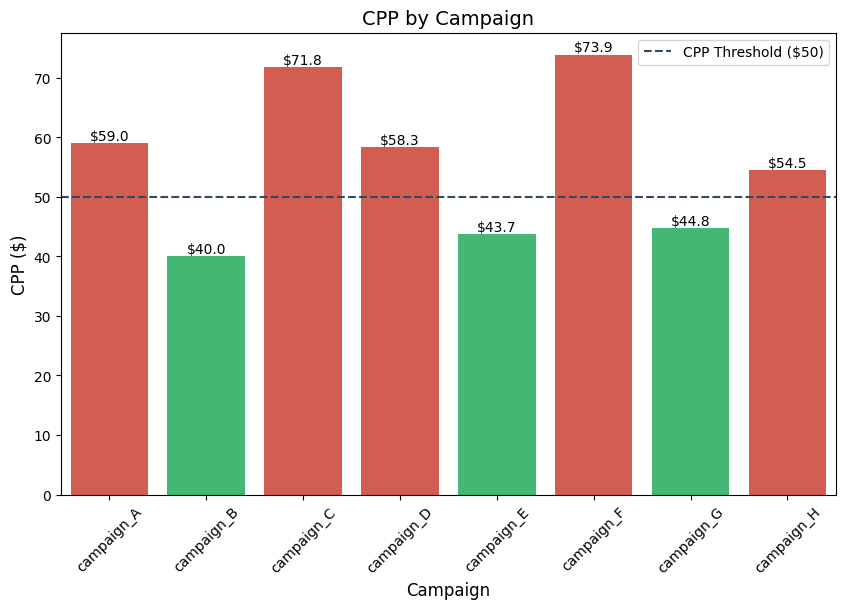

In [4]:
# 6. Визуализация результатов CPP по рекламным кампаниям
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=effectiveness_results.index,
    y='CPP',
    data=effectiveness_results,
    hue='effective',
    legend=False,
    palette=['#2ecc71' if x else '#e74c3c' for x in effectiveness_results['effective']]
)
plt.axhline(50, color='#34495e', linestyle='--', label='CPP Threshold ($50)')
plt.title('CPP by Campaign', fontsize=14)
plt.xlabel('Campaign', fontsize=12)
plt.ylabel('CPP ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
for p in ax.patches:
    ax.annotate(f'${p.get_height():.1f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')
plt.show()

## Выводы по задаче 1

### Результаты задачи
1. **Эффективные рекламные кампании (CPP ≤ 50):** `['campaign_B', 'campaign_E', 'campaign_G']`.
2. **Неэффективные рекламные кампании (CPP > 50):** `['campaign_A', 'campaign_C', 'campaign_D', 'campaign_F', 'campaign_H']`.

### Ограничения
1. **Ограничение по времени:** Анализ опирается на данные за **определенный период времени**, и результаты могут не быть репрезентативными для других периодов.
2. **Ограничение по критерию эффективности:**  Оценка эффективности базируется **исключительно на показателе CPP Day 7**. Не учитываются другие важные метрики, такие как **долгосрочная ценность клиента (LTV), удержание пользователей (Retention Rate)**, и другие факторы, влияющие на общую рентабельность инвестиций в рекламу.
3. **Ограничение по объему данных:** Анализ ограничен **доступными данными** и не учитывает потенциальное влияние внешних факторов, сезонности или изменений рыночной конъюнктуры.

### Рекомендации
1. **Рекомендации по эффективным кампаниям:**  **Рассмотреть масштабирование**  рекламных кампаний `campaign_B`, `campaign_E` и `campaign_G`.  Изучить **общие характеристики** этих кампаний (таргетинг, креативы, каналы) для выявления факторов успеха и их дальнейшего применения.
2. **Рекомендации по неэффективным кампаниям:**  Провести **углубленный анализ причин неэффективности** кампаний `campaign_A`, `campaign_C`, `campaign_D`, `campaign_F` и `campaign_H`.  **Пересмотреть настройки таргетинга, рекламные креативы и каналы** для оптимизации этих кампаний.  Возможно проведение **A/B тестирования** для улучшения их показателей.
3. **Дополнительные рекомендации:**  Для более комплексной оценки эффективности **рекомендуется учитывать и другие ключевые метрики**,  а также проводить **динамический анализ эффективности кампаний на протяжении более длительного периода времени.**  **Учитывая, что пользователи продолжают платить после 7 дней (как показал анализ ARPU и кумулятивного дохода в Задачах 2 и 5),  необходимо пересмотреть экономическую модель привлечения, возможно увеличив "окно" оценки эффективности за рамки 7 дней.**  Дальнейший анализ долгосрочной ценности привлеченных пользователей позволит принять более взвешенные решения о распределении рекламного бюджета.


#Задача 2: Aнализ воронок

Необходимо изучить метрики рекламной и продуктовой воронки по эффективным и
неэффективным рекламным кампаниям, затем определить/предположить, что могло
стать причиной неудовлетворительной эффективности для ряда кампаний.


## Алгоритм скрипта

1. Объединим данные для создания пути пользователя.
2. Рассчитаем ключевые метрики воронки (CTR, коэффициенты конверсии и т.д.).
3. Рассчитаем ROI, CAC, CLTV для каждой кампании.
4. Сегментируем кампании на эффективные и неэффективные группы на основе ROI или CPP.
5. Проанализируем различия между эффективными и неэффективными кампаниями, чтобы выявить факторы успеха и неудачи.
6. Визуализируем результаты для эффективной передачи выводов.
7. А дальше было решено исследовать общую воронку, ARPU и платежи.

## Воронка по группировке эффективные и неэффективные РК

In [5]:
# effective_campaigns = ['campaign_B', 'campaign_E', 'campaign_G']
# ineffective_campaigns = ['campaign_A', 'campaign_C', 'campaign_D', 'campaign_F', 'campaign_H']

# 1. Разделение данных на группы: эффективные и неэффективные РК
effective_ad_data = ad_data[ad_data['campaign'].isin(effective_campaigns)]
ineffective_ad_data = ad_data[ad_data['campaign'].isin(ineffective_campaigns)]
effective_registration = registration[registration['campaign'].isin(effective_campaigns)]
ineffective_registration = registration[registration['campaign'].isin(ineffective_campaigns)]
effective_tutorial = tutorial[tutorial['id'].isin(effective_registration['id'])]
ineffective_tutorial = tutorial[tutorial['id'].isin(ineffective_registration['id'])]
day7_payers_effective_reg_df = registration[registration['campaign'].isin(effective_campaigns) & registration['id'].isin(day7_payers_registration_df['id'])]
day7_payers_ineffective_reg_df = registration[registration['campaign'].isin(ineffective_campaigns) & registration['id'].isin(day7_payers_registration_df['id'])]

# 2. Расчет показателей рекламной воронки
effective_impressions = effective_ad_data['impressions'].sum()
effective_clicks = effective_ad_data['clicks'].sum()
ineffective_impressions = ineffective_ad_data['impressions'].sum()
ineffective_clicks = ineffective_ad_data['clicks'].sum()
effective_ctr = (effective_clicks / effective_impressions) if effective_impressions > 0 else 0
ineffective_ctr = (ineffective_clicks / ineffective_impressions) if ineffective_impressions > 0 else 0

# 3. Расчет показателей продуктовой воронки
effective_registrations = effective_registration['id'].nunique()
ineffective_registrations = ineffective_registration['id'].nunique()
effective_reg_rate = (effective_registrations / effective_clicks) if effective_clicks > 0 else 0
ineffective_reg_rate = (ineffective_registrations / ineffective_clicks) if ineffective_clicks > 0 else 0
effective_tutorial_completions = effective_tutorial['id'].nunique()
ineffective_tutorial_completions = ineffective_tutorial['id'].nunique()
effective_tut_comp_rate = (effective_tutorial_completions / effective_registrations) if effective_registrations > 0 else 0
ineffective_tut_comp_rate = (ineffective_tutorial_completions / ineffective_registrations) if ineffective_registrations > 0 else 0
effective_day7_payers = day7_payers_effective_reg_df['id'].nunique()
ineffective_day7_payers = day7_payers_ineffective_reg_df['id'].nunique()
effective_day7_payer_rate = (effective_day7_payers / effective_registrations) if effective_registrations > 0 else 0
ineffective_day7_payer_rate = (ineffective_day7_payers / ineffective_registrations) if ineffective_registrations > 0 else 0
effective_day7_payer_from_tutorial_rate = (effective_day7_payers / effective_tutorial_completions) if effective_tutorial_completions > 0 else 0
ineffective_day7_payer_from_tutorial_rate = (ineffective_day7_payers / ineffective_tutorial_completions) if ineffective_tutorial_completions > 0 else 0
effective_overall_conversion = (effective_day7_payers / effective_clicks) if effective_clicks > 0 else 0
ineffective_overall_conversion = (ineffective_day7_payers / ineffective_clicks) if ineffective_clicks > 0 else 0

# 4. Сводная таблица
summary_df = pd.DataFrame({
    'Campaign Group': ['Effective Campaigns', 'Ineffective Campaigns'],
    'Impressions': [effective_impressions, ineffective_impressions],
    'Clicks': [effective_clicks, ineffective_clicks],
    'CTR': [effective_ctr, ineffective_ctr],
    'Registrations': [effective_registrations, ineffective_registrations],
    'Registration % (RR)': [effective_reg_rate, ineffective_reg_rate],
    'Tutorial Passed': [effective_tutorial_completions, ineffective_tutorial_completions],
    'Tutorial % (TR)': [effective_tut_comp_rate, ineffective_tut_comp_rate],
    'd7 payers': [effective_day7_payers, ineffective_day7_payers],
    'd7 payer rate': [effective_day7_payer_rate, ineffective_day7_payer_rate],
    'd7 pay TR': [effective_day7_payer_from_tutorial_rate, ineffective_day7_payer_from_tutorial_rate],
    'd7 pay CR clicks2pay': [effective_overall_conversion, ineffective_overall_conversion]
})

print("\nЗадача 2: эффективные и неэффективные РК")
summary_df


Задача 2: эффективные и неэффективные РК


,Campaign Group,Impressions,Clicks,CTR,Registrations,Registration % (RR),Tutorial Passed,Tutorial % (TR),d7 payers,d7 payer rate,d7 pay TR,d7 pay CR clicks2pay
0,Effective Campaigns,201276,88525,0.439819,15067,0.170201,8114,0.538528,740,0.049114,0.091200,0.008359
1,Ineffective Campaigns,309925,133830,0.431814,22077,0.164963,10414,0.471713,960,0.043484,0.092184,0.007173


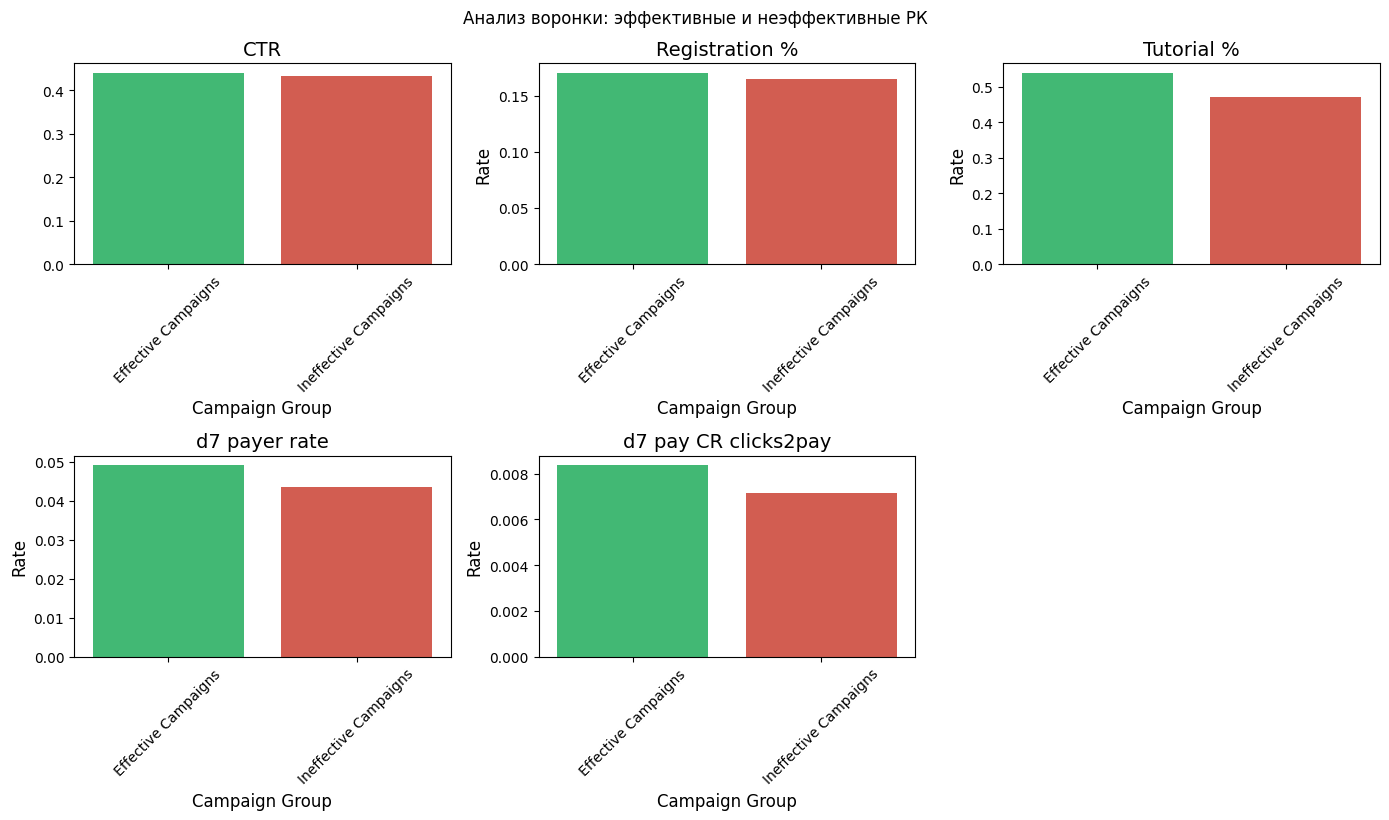

In [6]:
# 5. Визуализация для сравнения воронок
metrics_to_plot = [
    'CTR',
    'Registration % (RR)',
    'Tutorial % (TR)',
    'd7 payer rate',
    'd7 pay CR clicks2pay'
]

plt.figure(figsize=(14, 8))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.barplot(
        x='Campaign Group',
        y=metric,
        data=summary_df,
        palette=['#2ecc71', '#e74c3c'],
        hue='Campaign Group',
        legend=False
    )
    plt.title(metric.split('(')[0].strip())
    plt.xticks(rotation=45)
    plt.ylabel('Rate' if i > 1 else '')
plt.tight_layout()
plt.suptitle('Анализ воронки: эффективные и неэффективные РК', y=1.02)
plt.show()

## Наблюдения и выводы

### Основные наблюдения

1.  **CTR:**  Показатель кликабельности (CTR) незначительно выше у эффективных кампаний (0.440 vs 0.432), но разница несущественна. Это говорит о схожем качестве рекламных объявлений или их релевантности для аудитории обеих групп кампаний.
2.   **Registration Rate (RR):**  Эффективные кампании демонстрируют немного более высокую конверсию кликов в регистрации (17.0% vs 16.5%), что может указывать на несколько лучшее качество трафика или посадочных страниц.
3.  **Tutorial Completion Rate (TR):**  Конверсия в прохождение обучения выше у эффективных кампаний (53.9% vs 47.2%). Это может говорить о более заинтересованной аудитории или лучшей адаптации пользователей, привлеченных эффективными РК.
4.   **Day 7 Payer Rate:**  Доля платящих в первые 7 дней пользователей (d7 payer rate)  немного выше у эффективных кампаний (4.9% vs 4.3%), что соответствует критерию эффективности, но разница не кардинальна.
5.   **Overall Conversion (clicks2pay):** Общая конверсия из клика в платящего пользователя также незначительно выше у эффективных кампаний (0.84% vs 0.72%).

### Предварительные выводы

1. Различия в показателях воронки между эффективными и неэффективными кампаниями **не являются резкими**, но прослеживается **небольшое преимущество эффективных кампаний на каждом этапе воронки**. Это может указывать на то, что эффективность кампаний обусловлена **комплексом факторов, влияющих на качество трафика и вовлечение пользователей на более поздних этапах воронки**, а не только на привлекательности самих объявлений (CTR).

2. Графики подчеркивают, что **эффективность кампаний проявляется не столько на верхних этапах воронки (CTR, RR), сколько на этапе вовлечения и монетизации пользователей (TR, d7 payer rate).**



## Overall воронка РК

Кроме разбивки эффективная/неэффективная, как необходимо по ТЗ, я решил проанализировать paid воронку в целом. Не переключайтесь)

In [8]:
# 1. Построение воронки
funnel = registration.merge(
    tutorial[['id']].drop_duplicates().assign(tutorial_completed=1),
    on='id',
    how='left'
).merge(
    payment.groupby('id')['payment'].sum().reset_index(),
    on='id',
    how='left'
)

# 2. Расчет конверсий
campaign_stats = funnel.groupby('campaign').agg(
    total_registrations=('id', 'nunique'),
    tutorial_completed=('tutorial_completed', 'sum'),
    paying_users=('payment', 'count'),
    total_revenue=('payment', 'sum'),
    average_purchase_value=('payment', 'mean')
).reset_index()

campaign_stats['tutorial_conversion'] = campaign_stats['tutorial_completed'] / campaign_stats['total_registrations']
campaign_stats['payer_conversion'] = campaign_stats['paying_users'] / campaign_stats['total_registrations']

# 3. Расчет метрик
ad_costs = ad_data.groupby('campaign').agg(
    total_cost=('costs', 'sum'),
    total_clicks=('clicks', 'sum'),
    total_impressions=('impressions', 'sum')
).reset_index()

campaign_performance = campaign_stats.merge(ad_costs, on='campaign', how='outer')

campaign_performance['registration_conversion'] = campaign_performance['total_registrations'] / registration['id'].nunique()
campaign_performance['ROI'] = np.where(campaign_performance['total_cost'].fillna(0) != 0,
                                            (campaign_performance['total_revenue'] - campaign_performance['total_cost']) / campaign_performance['total_cost'],
                                            0)
campaign_performance['CPC'] = np.where(campaign_performance['total_clicks'].fillna(0) != 0,
                                            campaign_performance['total_cost'] / campaign_performance['total_clicks'],
                                            0)
campaign_performance['CTR'] = np.where(campaign_performance['total_impressions'].fillna(0) != 0,
                                            campaign_performance['total_clicks'] / campaign_performance['total_impressions'],
                                            0)
campaign_performance['CAC'] = np.where(campaign_performance['total_registrations'].fillna(0) != 0,
                                            campaign_performance['total_cost'] / campaign_performance['total_registrations'],
                                            0)
campaign_performance['cost_per_payer'] = np.where(campaign_performance['paying_users'].fillna(0) != 0,
                                                    campaign_performance['total_cost'] / campaign_performance['paying_users'],
                                                    0)
campaign_performance['revenue_per_payer'] = np.where(campaign_performance['paying_users'].fillna(0) != 0,
                                                    campaign_performance['total_revenue'] / campaign_performance['paying_users'],
                                                    0)
campaign_performance['CLTV'] = np.where(campaign_performance['total_registrations'].fillna(0) != 0,
                                            campaign_performance['average_purchase_value'] * campaign_performance['paying_users'] / campaign_performance['total_registrations'],
                                            0)

# 2.1. Добавим критерии эффективности из ТЗ
campaign_performance['effective'] = campaign_performance['cost_per_payer'] <= 50

# 3. Отчеты
campaign_overall_report = campaign_performance[[
    'campaign',
    'payer_conversion',
    'revenue_per_payer',
    'cost_per_payer',
    'effective'
]].fillna(0)
# .sort_values(by='cost_per_payer')

print("Campaign Overall Report:")
print(campaign_overall_report.to_string(index=False))

campaign_report = campaign_performance[[
    'campaign',
    'total_impressions',
    'CTR',
    'CPC',
    'CAC',
    'ROI',
    'CLTV',
    'total_registrations',
    'effective'
]].fillna(0)
# .sort_values(by='ROI', ascending=False)

print("\nCampaign Performance Report:")
print(campaign_report.to_string(index=False))

pnl_report = campaign_performance[[
    'campaign',
    'total_cost',
    'total_revenue',
    'cost_per_payer',
    'revenue_per_payer',
    'ROI',
    'effective'
]].fillna(0)
# .sort_values(by='ROI', ascending=False)

print("\nPNL Report:")
print(pnl_report.to_string(index=False))

funnel_report = campaign_performance[[
    'campaign',
    'total_registrations',
    'registration_conversion',
    'tutorial_completed',
    'tutorial_conversion',
    'paying_users',
    'payer_conversion',
    'effective'
]].fillna(0)
# .sort_values(by='payer_conversion', ascending=False)

print("\nFunnel Report:")
print(funnel_report.to_string(index=False))

Campaign Overall Report:
  campaign  payer_conversion  revenue_per_payer  cost_per_payer  effective
campaign_A          0.049352          91.254686            59.0      False
campaign_B          0.050279          10.714159            40.0       True
campaign_C          0.050176          58.843837            71.8      False
campaign_D          0.047970          71.901731            58.3      False
campaign_E          0.049010          95.255539            43.7       True
campaign_F          0.048916          66.758227            73.9      False
campaign_G          0.049256          67.536083            44.8       True
campaign_H          0.039871          59.882258            54.5      False

Campaign Performance Report:
  campaign  total_impressions      CTR      CPC      CAC       ROI     CLTV  total_registrations  effective
campaign_A              35896 0.439687 0.370082 2.911765  0.546690 4.503596                 2006      False
campaign_B               2384 0.439597 0.343511 2.0111

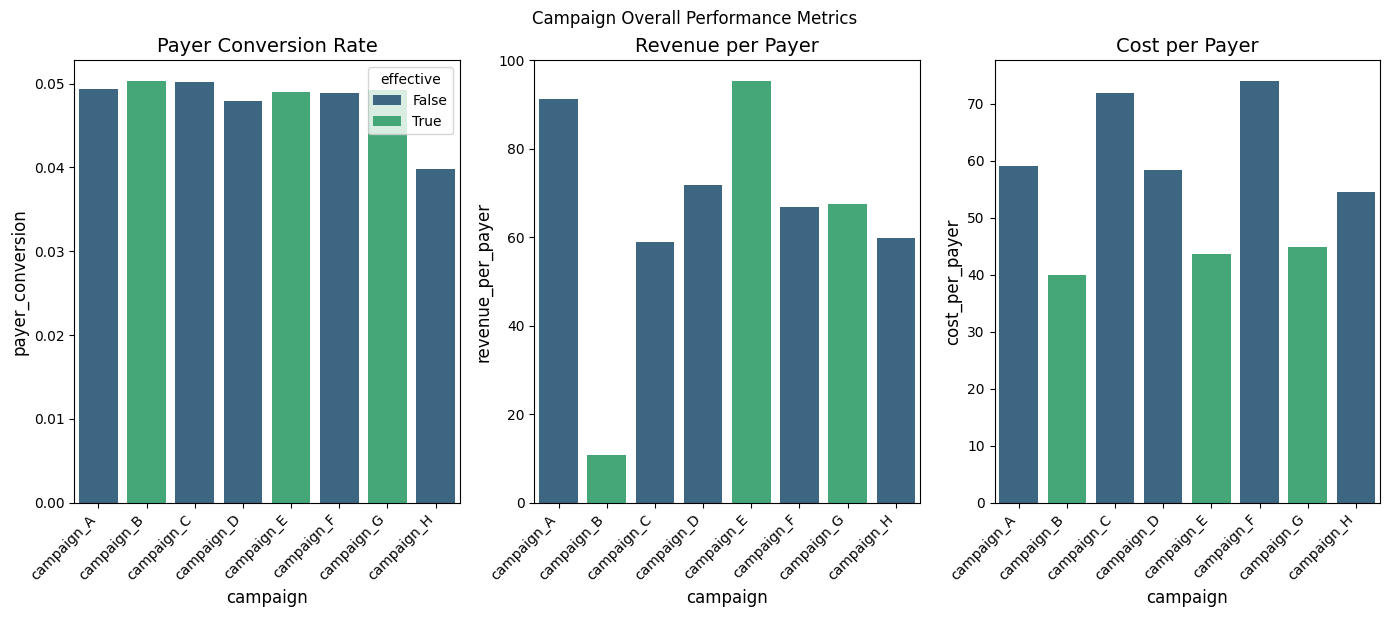

In [9]:
# 4. Визуализация для Campaign Overall Report
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='campaign', y='payer_conversion', data=campaign_overall_report, palette='viridis', hue='effective', legend=True)
plt.title('Payer Conversion Rate')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
sns.barplot(x='campaign', y='revenue_per_payer', data=campaign_overall_report, palette='viridis', hue='effective', legend=False)
plt.title('Revenue per Payer')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
sns.barplot(x='campaign', y='cost_per_payer', data=campaign_overall_report, palette='viridis', hue='effective', legend=False)
plt.title('Cost per Payer')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.suptitle('Campaign Overall Performance Metrics', y=1.02)
plt.show()

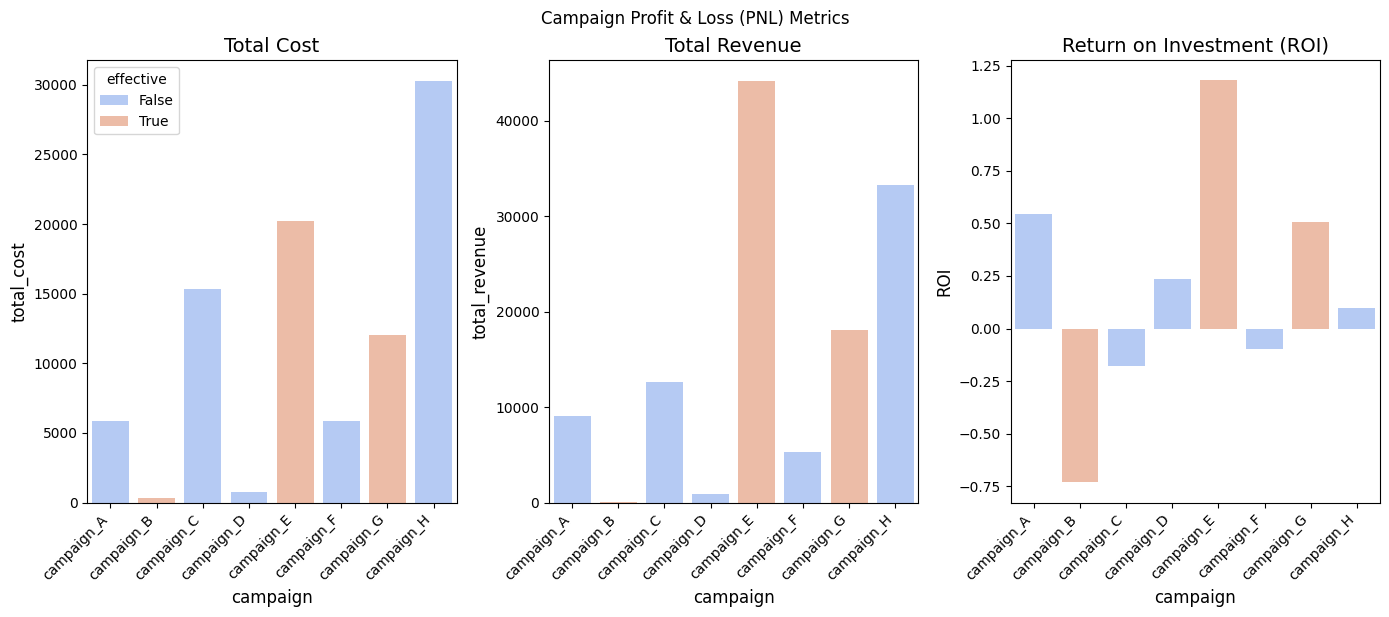

In [10]:
# 6. Визуализация для PNL Report
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='campaign', y='total_cost', data=pnl_report, palette='coolwarm', hue='effective', legend=True)
plt.title('Total Cost')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 2)
sns.barplot(x='campaign', y='total_revenue', data=pnl_report, palette='coolwarm', hue='effective', legend=False)
plt.title('Total Revenue')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 3, 3)
sns.barplot(x='campaign', y='ROI', data=pnl_report, palette='coolwarm', hue='effective', legend=False)
plt.title('Return on Investment (ROI)')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.suptitle('Campaign Profit & Loss (PNL) Metrics', y=1.02)
plt.show()

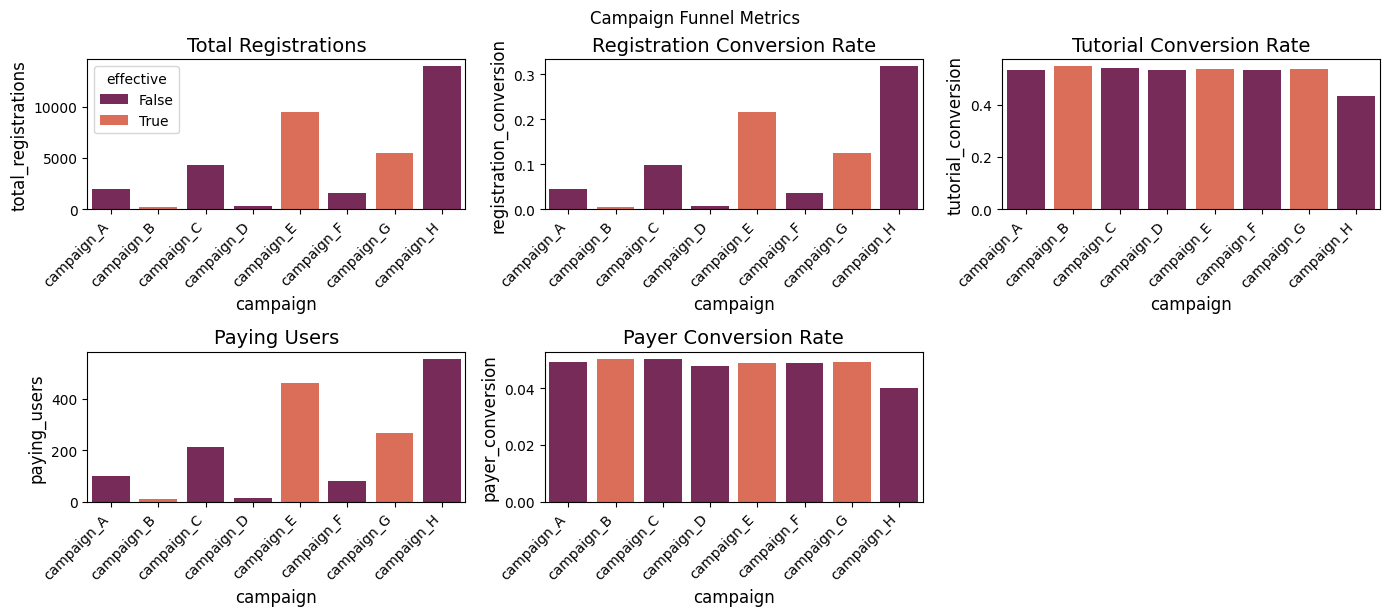

In [11]:
# 7. Визуализация для Funnel Report
plt.figure(figsize=(14, 6))

plt.subplot(2, 3, 1)
sns.barplot(x='campaign', y='total_registrations', data=funnel_report, palette='rocket', hue='effective', legend=True)
plt.title('Total Registrations')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 3, 2)
sns.barplot(x='campaign', y='registration_conversion', data=funnel_report, palette='rocket', hue='effective', legend=False)
plt.title('Registration Conversion Rate')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 3, 3)
sns.barplot(x='campaign', y='tutorial_conversion', data=funnel_report, palette='rocket', hue='effective', legend=False)
plt.title('Tutorial Conversion Rate')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 3, 4)
sns.barplot(x='campaign', y='paying_users', data=funnel_report, palette='rocket', hue='effective', legend=False)
plt.title('Paying Users')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 3, 5)
sns.barplot(x='campaign', y='payer_conversion', data=funnel_report, palette='rocket', hue='effective', legend=False)
plt.title('Payer Conversion Rate')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.suptitle('Campaign Funnel Metrics', y=1.02)
plt.show()

## Наблюдения и выводы по РК

### Основные наблюдения
1.   **Campaign Overall Report:**  Подтверждает результаты задачи 1: кампании **B, E, G эффективны** (CPP < $50), остальные – неэффективны.  **Revenue per Payer** значительно варьируется между кампаниями, но не всегда коррелирует с эффективностью по CPP. Например, кампания E имеет самый высокий Revenue per Payer, но кампания B – значительно ниже, при этом обе эффективны.
2.  **Campaign Performance Report:**  **CTR** у всех кампаний достаточно **близкий**, за исключением campaign_F (ниже).  **CPC** варьируется, но явной связи с эффективностью не прослеживается. **CAC** прямо коррелирует с CPP (логично, так как CAC влияет на CPP). **ROI** отрицательный у неэффективных кампаний C и F, и у кампании B (хотя она эффективна по CPP -  нужно обратить внимание).  **CLTV** (Customer Lifetime Value) также варьируется, но не дает четкой картины, коррелирующей с эффективностью по CPP.
3.   **PNL Report:**  Подтверждает, что **неэффективные кампании (C, F, H) приносят убытки или минимальную прибыль**, в то время как эффективные (E, G) –  более прибыльные (кроме B, ROI отрицательный).
4.   **Funnel Report:**  **Registration Conversion Rate (RR)**  значительно различается между кампаниями, самая высокая у campaign_H и campaign_E.  **Tutorial Conversion Rate (TR)** относительно стабилен между кампаниями (около 54%), кроме campaign_H (ниже - 43%). **Payer Conversion Rate** также  достаточно близок для всех кампаний, кроме campaign_H (заметно ниже).

### Предварительные выводы

1.   **Эффективность по CPP не всегда означает высокую общую прибыльность (ROI) в рамках рассматриваемого периода.**  Пример campaign_B – эффективна по CPP, но ROI отрицательный.  Возможно, кампания требует больше времени на "окупаемость" или имеет другие долгосрочные выгоды, не учтенные в Day 7 CPP.
2.   **CTR и CPC не являются ключевыми факторами, определяющими эффективность.** Различия в CTR между кампаниями малы, а CPC не коррелирует явно с эффективностью.
3.   **Конверсия в регистрацию (RR) и прохождение обучения (TR)  имеют большее значение для эффективности**, но также не являются единственным определяющим фактором.  Campaign_H имеет высокую RR, но низкую payer_conversion и неэффективна по CPP.
4.   **Низкая эффективность ряда кампаний (A, C, D, F, H) может быть связана с более высоким CAC и, как следствие, более высоким CPP**, при схожих или даже более высоких значениях RR и TR, чем у эффективных кампаний.  Это говорит о **возможном перерасходе бюджета на привлечение пользователей в этих кампаниях при сопоставимом качестве трафика на верхних этапах воронки.**

## ARPU

После анализа маркетинговой воронки я решил спуститься поглубже в продуктовую и исследовать ARPU.

In [12]:
## ARPU

# 1. Подготовка данных для расчета ARPU
merged_df = pd.merge(registration, payment, on='id', how='left')

# 2. Расчет разницы во времени между платежом и регистрацией
merged_df['time_diff'] = (merged_df['pay_ts'] - merged_df['reg_ts']).dt.days

# 3. Функция для расчета ARPU
def calculate_arpu(df, days):
    filtered_df = df[df['time_diff'] <= days]
    user_spending = filtered_df.groupby(['campaign', 'id'])['payment'].sum().reset_index()
    arpu = user_spending.groupby('campaign')['payment'].sum() / user_spending.groupby('campaign')['id'].nunique()
    return round(arpu, 1).reset_index(name=f'{days} Days ARPU')

# 4. Расчет ARPU за разные временные окна
arpu_7d = calculate_arpu(merged_df, 7)
arpu_14d = calculate_arpu(merged_df, 14)
arpu_30d = calculate_arpu(merged_df, 30)
arpu_90d = calculate_arpu(merged_df, 90)
arpu_180d = calculate_arpu(merged_df, 180)

# 5. Создание отчета с ARPU
report = arpu_7d.merge(arpu_14d, on='campaign', how='outer') \
                .merge(arpu_30d, on='campaign', how='outer') \
                .merge(arpu_90d, on='campaign', how='outer') \
                .merge(arpu_180d, on='campaign', how='outer')

# 6. Вывод отчета
print("ARPU Report:")
report

ARPU Report:


,campaign,7 Days ARPU,14 Days ARPU,30 Days ARPU,90 Days ARPU,180 Days ARPU
0,campaign_A,10.6,15.0,22.6,60.1,79.4
1,campaign_B,5.8,6.8,8.8,10.7,10.7
2,campaign_C,6.5,9.4,14.6,34.4,52.8
3,campaign_D,37.4,44.5,52.0,71.9,71.9
4,campaign_E,15.4,21.7,35.8,61.8,89.2
5,campaign_F,8.0,10.0,14.2,44.6,60.4
6,campaign_G,10.2,14.6,23.9,45.9,60.5
7,campaign_H,7.8,12.4,21.9,39.0,55.2


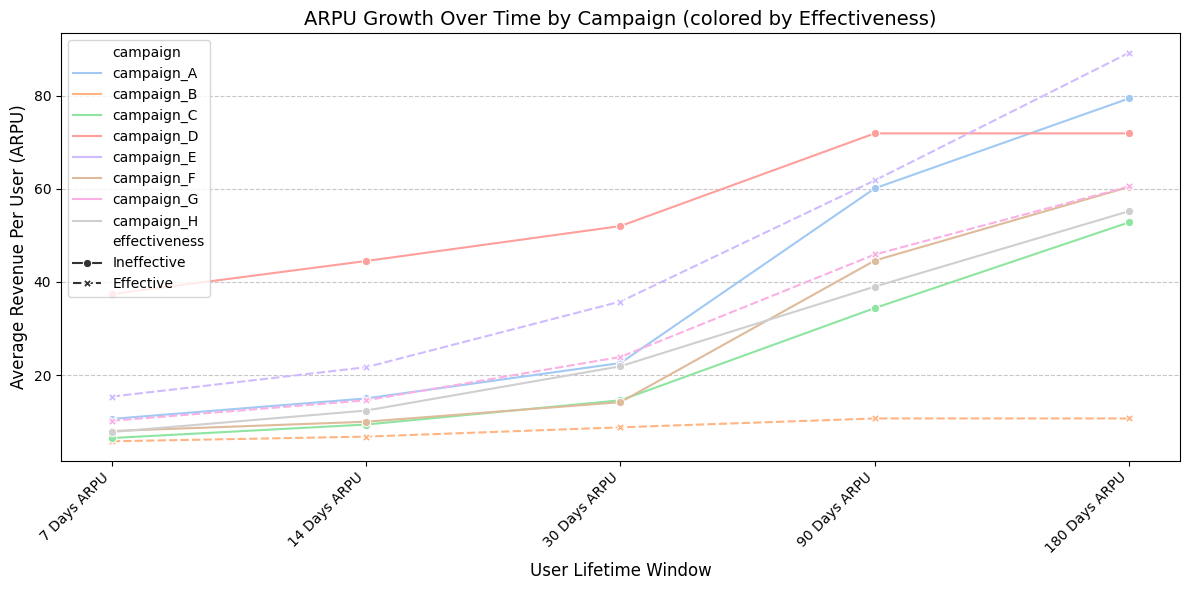

In [13]:
# 7. Визуализация для ARPU Report
effective_campaigns = ['campaign_B', 'campaign_E', 'campaign_G']
ineffective_campaigns = ['campaign_A', 'campaign_C', 'campaign_D', 'campaign_F', 'campaign_H']

report['effectiveness'] = report['campaign'].apply(lambda x: 'Effective' if x in effective_campaigns else 'Ineffective')

report_melted = pd.melt(report,
                      id_vars=['campaign', 'effectiveness'],
                      value_vars=['7 Days ARPU', '14 Days ARPU', '30 Days ARPU', '90 Days ARPU', '180 Days ARPU'],
                      var_name='Time Window',
                      value_name='ARPU')

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time Window', y='ARPU', hue='campaign', style='effectiveness', markers=True, data=report_melted)

plt.xlabel('User Lifetime Window')
plt.ylabel('Average Revenue Per User (ARPU)')
plt.title('ARPU Growth Over Time by Campaign (colored by Effectiveness)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Наблюдения и выводы по ARPU

### Основные наблюдения

1. **Рост ARPU со временем**:  Для всех кампаний наблюдается **значительный рост ARPU с увеличением lifetime пользователя** (от 7 до 180 дней). Различия в динамике ARPU между кампаниями:
    *   **campaign_A, campaign_C, campaign_E, campaign_G**:  Демонстрируют **наиболее выраженный рост ARPU** в долгосрочной перспективе (90-180 дней).  Это может указывать на то, что пользователи, привлеченные этими кампаниями, имеют **высокий lifetime value**, несмотря на то, что некоторые из них (A, C) не были признаны эффективными по Day 7 CPP.
    *   **campaign_B**:  Показывает **минимальный рост ARPU** и **самые низкие значения ARPU на всех временных интервалах.**  Несмотря на эффективность по Day 7 CPP, **долгосрочная ценность пользователей, привлеченных этой кампанией, может быть ограничена.**
    *   **campaign_D, campaign_F, campaign_H**:  Демонстрируют **средний рост ARPU**,  занимая **промежуточное положение по значениям ARPU** между группами лидеров и аутсайдеров.

### Предварительные выводы

1. **Оценка эффективности кампаний, основанная исключительно на Day 7 CPP, может быть недостаточной и не учитывать долгосрочный потенциал пользователей.**  
2. Кампании, неэффективные по Day 7 CPP (например, campaign_A, campaign_C), могут демонстрировать **высокий ARPU на более длинных дистанциях (90-180 дней)**, что может **изменить общую оценку их рентабельности** при долгосрочном рассмотрении.
3. **Необходимо учитывать динамику ARPU и lifetime value пользователей при оценке эффективности рекламных кампаний и принятии решений о бюджетировании.**  Фокус только на Day 7 CPP может привести к **отказу от перспективных кампаний с высоким LTV, но более медленной окупаемостью.**
4. **Campaign_B, несмотря на эффективность по Day 7 CPP,  выглядит наименее перспективной в долгосрочной перспективе из-за низкого и слабо растущего ARPU.**

## Recurring payers and payment counts

И после исследования ARPU, я хотел бы понять количество и качество платежей, но добавив еще платежи со всех каналов из датасета: organic и paid. Вот что получилось

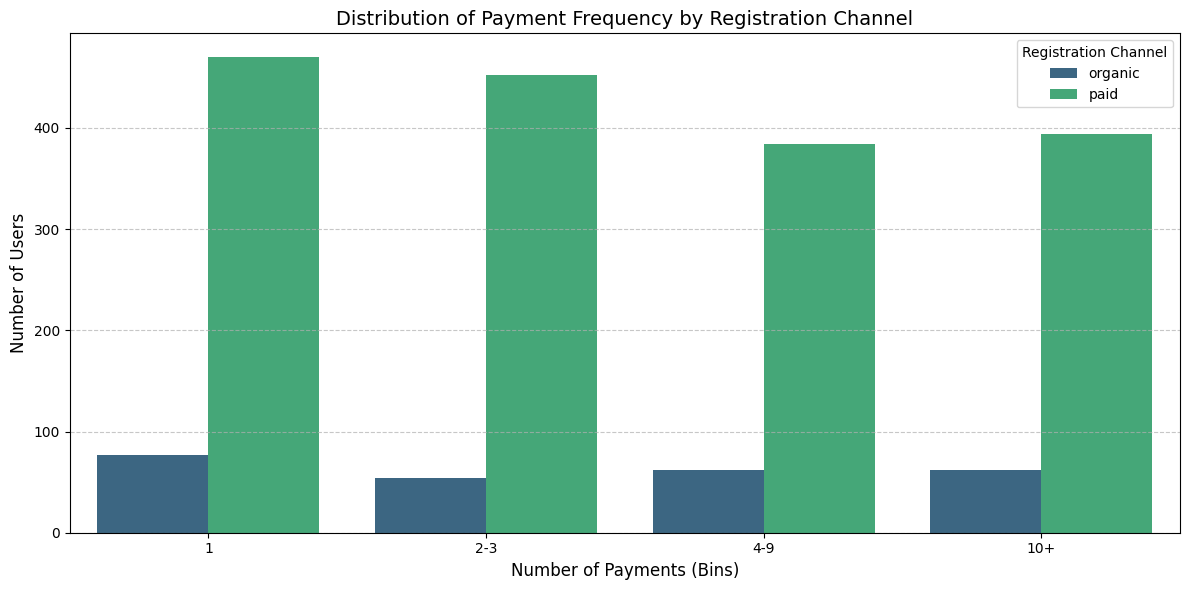


Сводная статистика частоты платежей:
count    1955.000000
mean       15.060870
std        43.808529
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       530.000000
Name: num_payments, dtype: float64

Доля пользователей с повторными платежами: 72.0%


In [14]:
## Recurring payers and payment counts

# 1. Подсчет количества платежей и распределение по каналам
payments_counts_per_channel = payment.merge(registration[['id', 'channel']], on='id', how='left').groupby(['channel', 'id'])['payment'].count().reset_index(name='num_payments')

# 2. Разбиение количества платежей на бины
payments_counts_per_channel['payment_bins'] = pd.cut(payments_counts_per_channel['num_payments'], bins=[0, 1, 3, 9, float('inf')], labels=['1', '2-3', '4-9', '10+'])

# 3. Визуализация распределения количества платежей по каналам
plt.figure(figsize=(12, 6))
sns.countplot(data=payments_counts_per_channel, x='payment_bins', hue='channel', palette='viridis')
plt.title('Distribution of Payment Frequency by Registration Channel')
plt.xlabel('Number of Payments (Bins)')
plt.ylabel('Number of Users')
plt.legend(title='Registration Channel')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 4. Сводная статистика по количеству платежей
print("\nСводная статистика частоты платежей:")
payment_counts = payments_counts_per_channel.groupby('id')['num_payments'].sum().reset_index()
print(payment_counts['num_payments'].describe())

# 5. Расчет процента пользователей с повторными платежами
recurring_users = payment_counts[payment_counts['num_payments'] > 1]['id'].nunique()
total_users = payment_counts['id'].nunique()
print(f"\nДоля пользователей с повторными платежами: {recurring_users / total_users:.1%}")

## Наблюдения и выводы по платежам

### Основные наблюдения

1. **Доминирование пользователей с повторными платежами**:  **72% платящих пользователей** совершают **более одного платежа**, что говорит о **высокой склонности к повторным покупкам** среди платящей аудитории в целом.
2. Распределение платежей:
    *   **Наибольшая доля пользователей (25%)** совершает **1 платеж**.
    *   **Значительная доля (25% - 50% квартили)** совершает **2-3 платежа.**
    *   **Более 25% пользователей** совершают **4 и более платежей**,  включая **значительную группу "heavy payers" (более 10 платежей)**.  **Максимальное количество платежей достигает 530**, что указывает на наличие **ядра лояльных и высокоплатящих пользователей.**
3. **Схожее распределение по каналам**:  Визуально **распределение частоты платежей по бинам выглядит схожим для Paid и Organic каналов**.  Это может говорить о том, что **склонность к повторным платежам не сильно зависит от канала привлечения**, а скорее определяется **общими характеристиками игры и аудитории, которая в нее вовлекается.**

### Предварительные выводы

1. **Рекуррентные платежи играют ключевую роль в монетизации.**  Высокая доля пользователей с повторными платежами подчеркивает **важность удержания и развития платящей аудитории** для бизнес-модели.
2. **Фокус на LTV**:  Результаты анализа рекуррентных платежей **дополнительно подтверждают необходимость учитывать LTV при оценке эффективности рекламных кампаний.**  Привлечение пользователей, склонных к повторным платежам, может быть **более ценным в долгосрочной перспективе**, даже если CPP на первом этапе выглядит выше.
3. **Возможность сегментации и персонализации**:  Наличие **значительной группы "heavy payers"**  открывает возможности для **сегментации аудитории и персонализации предложений** для **максимизации LTV** наиболее ценных пользователей.
4. **Дальнейшее исследование каналов**:  Несмотря на схожее распределение по каналам, **рекомендуется более детальный анализ LTV и рекуррентных платежей в разбивке по каналам (Paid vs Organic и по отдельным РК)**, чтобы **выявить возможные различия в долгосрочной ценности пользователей, привлеченных разными каналами и кампаниями.**

## Финальные выводы по задаче 2

### Основные выводы

1. **Неоднозначность оценки эффективности на основе Day 7 CPP:** Анализ воронок и ARPU показал, что **ориентация исключительно на Day 7 CPP для оценки эффективности рекламных кампаний может быть недостаточной.**  **Ряд кампаний, признанных неэффективными по Day 7 CPP (A, C, D, F, H), демонстрируют высокий потенциал долгосрочной монетизации (высокий и растущий ARPU).**  В то же время, **кампания B, эффективная по Day 7 CPP, выглядит наименее перспективной в долгосрочной перспективе из-за низкого LTV.**
2. **Важность LTV и рекуррентных платежей:**  Анализ ARPU и рекуррентных платежей **подчеркнул ключевую роль долгосрочной ценности пользователя (LTV) и рекуррентной выручки для бизнес-модели.**  **Высокая доля пользователей с повторными платежами (72%)** и **значительный рост ARPU со временем**  указывают на то, что **основная прибыль от привлеченных пользователей формируется не в первые 7 дней, а на более длительном горизонте.**
3. **Возможные причины неэффективности ряда кампаний (A, C, D, F, H) по Day 7 CPP:**
    *   **Завышенный CAC:**  Предварительный анализ воронок показал, что **неэффективные кампании могут иметь более высокий CAC**, что напрямую влияет на CPP.  Возможно, это связано с **менее оптимальными настройками таргетинга, более высокой конкуренцией в аукционе или неэффективными креативами, приводящими к перерасходу бюджета на привлечение регистраций.**
    *   **Более длительный цикл монетизации:**  Не исключено, что **пользователи, привлеченные неэффективными по Day 7 CPP кампаниями, требуют больше времени на "разогрев" и совершение первых платежей.**  При этом, как показал анализ ARPU, **их долгосрочный платежный потенциал может быть высоким.**
    *   **Недостаточная оптимизация продуктовой воронки для определенной аудитории:**  Хотя различия в конверсиях на этапах продуктовой воронки между эффективными и неэффективными кампаниями невелики, **нельзя исключать, что существуют нюансы во взаимодействии пользователей, привлеченных разными кампаниями, с продуктом**: туториалом, онбордингом, игровым процессом, которые влияют на их  готовность платить в первые 7 дней.

### Рекомендации

1. **Пересмотреть критерии эффективности:** Сместить фокус оценки эффективности рекламных кампаний с краткосрочного Day 7 CPP на более долгосрочные метрики, такие как ROI и LTV 30 дня (или дольше).  Установить **пороги рентабельности для ROI и LTV**,  которые будут использоваться в качестве основных KPI.
2. **Оптимизация CAC для неэффективных кампаний:**  Провести детальный анализ расходов и настроек неэффективных кампаний (A, C, D, F, H) для выявления возможностей снижения CAC.
3. **Исследование LTV в разбивке по кампаниям и каналам:**  Провести более глубокий анализ LTV и динамики платежей для каждой кампании и канала привлечения. Выявить наиболее ценные сегменты аудитории и каналы, обеспечивающие максимальный LTV.
4. **A/B тестирование продуктовой воронки:**  Провести A/B тестирование различных элементов продуктовой воронки: туториала, онбординга, первых игровых шагов для пользователей, привлеченных разными кампаниями, чтобы выявить  возможности повышения конверсии в платеж на ранних этапах для "неэффективных" кампаний.
5. **Перераспределение бюджета:**  Пересмотреть распределение рекламного бюджета в пользу кампаний с высоким LTV (например, A, C, E, G),  **даже если их Day 7 CPP выше порога, но долгосрочная рентабельность выглядит более привлекательной.**  Ограничить или приостановить инвестиции в кампании с низким LTV (например, B), даже при  "хорошем" Day 7 CPP.

#Задача 3: Проверка гипотезы ARPU_7

UA менеджер утверждает, что пользователи, привлеченные кампаниями E и H,
идентичны по платежному поведению и принадлежат одной популяции. Подтвердите
или опровергните эту гипотезу, основываясь на статистическом выводе о сходстве или различии в метрике ARPU_7 между двумя группами.

ARPU_7 это кумулятивная метрика, равная отношению суммарной выручки за первые
7 дней жизни пользователей (за первые 0-168 часов жизни для каждого пользователя), к количеству установок в когорте.

## Методология

1. **Фильтрация данных регистрации для кампаний E и H:**  Выделение данных о регистрациях и платежах пользователей, привлеченных рекламными кампаниями `campaign_E` и `campaign_H` из общего датасета `registration`. + Расчет ARPU_7.
2. **Подготовка данных о платежах для статистического теста:**  Формирование выборок данных о Day 7 платежах для кампаний E и H (`payments_E` и `payments_H`) для проведения статистического сравнения.
3. **Проверка нормальности распределения платежей для кампаний E и H:**  Оценка типа распределения данных о платежах для каждой кампании с использованием визуализации (гистограмма и Q-Q plot) и формального статистического теста Шапиро-Уилка.
4. **Выбор статистического теста:** На основании результатов проверки нормальности (установленной ненормальности распределений), выбор непараметрического Mann-Whitney U теста для сравнения ARPU_7 между кампаниями E и H.
5. **Проведение Mann-Whitney U теста:**  Применение Mann-Whitney U теста для проверки гипотезы о равенстве распределений ARPU_7 для кампаний E и H (нулевая гипотеза) против альтернативной гипотезы о различии распределений.

## Скрипт эксперимента ARPU_7

In [15]:
# 1. Фильтрация данных для кампаний E и H
registration_E = registration[registration['campaign'] == 'campaign_E']
registration_H = registration[registration['campaign'] == 'campaign_H']

merged_reg_pay_E = pd.merge(registration_E, payment, on='id', how='inner')
merged_reg_pay_E['lifetime'] = merged_reg_pay_E['pay_ts'] - merged_reg_pay_E['reg_ts']
day7_payments_E = merged_reg_pay_E[merged_reg_pay_E['lifetime'] <= pd.Timedelta(days=7)]
total_revenue_E = day7_payments_E['payment'].sum()
num_users_E = registration_E['id'].nunique()
arpu_7_E = total_revenue_E / num_users_E if num_users_E > 0 else 0


merged_reg_pay_H = pd.merge(registration_H, payment, on='id', how='inner')
merged_reg_pay_H['lifetime'] = merged_reg_pay_H['pay_ts'] - merged_reg_pay_H['reg_ts']
day7_payments_H = merged_reg_pay_H[merged_reg_pay_H['lifetime'] <= pd.Timedelta(days=7)]
total_revenue_H = day7_payments_H['payment'].sum()
num_users_H = registration_H['id'].nunique()
arpu_7_H = total_revenue_H / num_users_H if num_users_H > 0 else 0

print(f"Campaign E ARPU_7: ${arpu_7_E:.2f}")
print(f"Campaign H ARPU_7: ${arpu_7_H:.2f}")

Campaign E ARPU_7: $0.68
Campaign H ARPU_7: $0.29


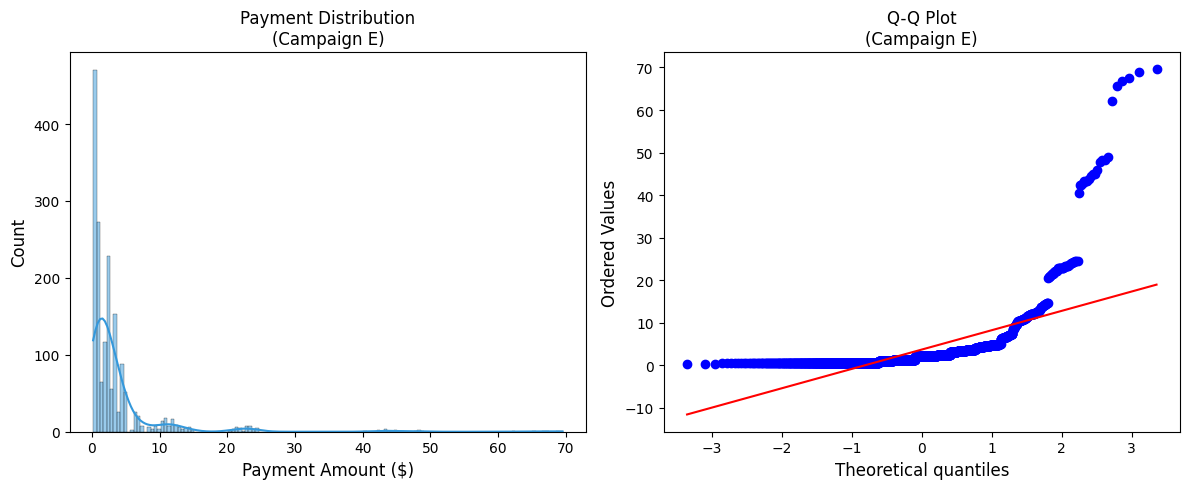

Shapiro-Wilk Test (Campaign E):
Statistic: 0.4494, p-value: 0.0000
Распределение НЕ нормальное (отвергаем H0)



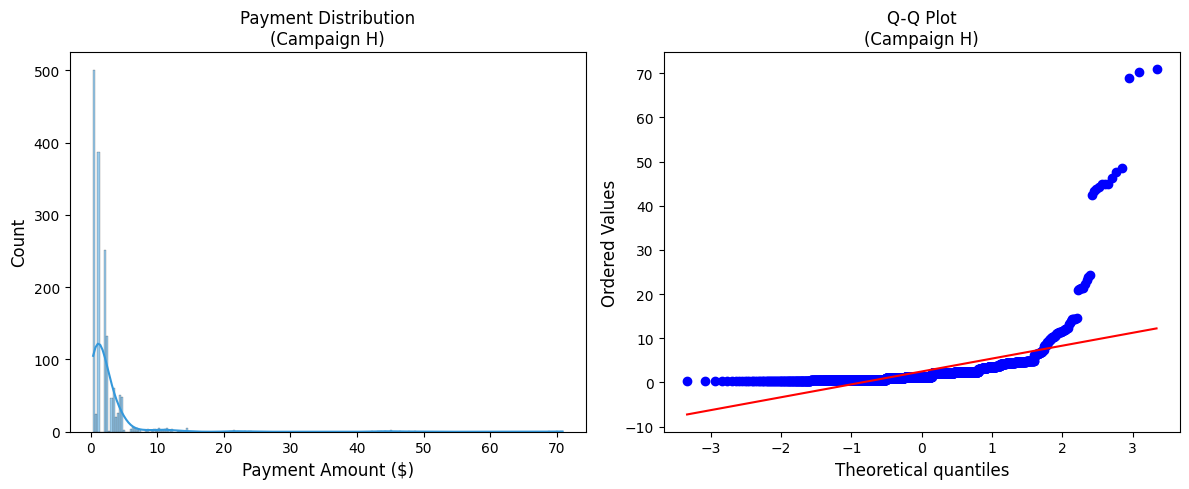

Shapiro-Wilk Test (Campaign H):
Statistic: 0.3279, p-value: 0.0000
Распределение НЕ нормальное (отвергаем H0)

Sample size check:
Campaign E: 1,752 observations
Campaign H: 1,640 observations


In [23]:
# 2. Проверка нормальности распределения платежей
payments_E = day7_payments_E['payment']
payments_H = day7_payments_H['payment']

def check_normality(data, campaign_name):
    plt.figure(figsize=(12, 5))

    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, color='#3498db')
    plt.title(f'Payment Distribution\n({campaign_name})', fontsize=12)
    plt.xlabel('Payment Amount ($)')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot\n({campaign_name})', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Тест Шапиро-Уилка
    shapiro_stat, shapiro_p = stats.shapiro(data)
    print(f"Shapiro-Wilk Test ({campaign_name}):")
    print(f"Statistic: {shapiro_stat:.4f}, p-value: {shapiro_p:.4f}")
    if shapiro_p > 0.05:
        print("Распределение нормальное (не удалось отвергнуть H0\n")
    else:
        print("Распределение НЕ нормальное (отвергаем H0)\n")

check_normality(payments_E, 'Campaign E')
check_normality(payments_H, 'Campaign H')

print(f"Sample size check:")
print(f"Campaign E: {len(payments_E):,} observations")
print(f"Campaign H: {len(payments_H):,} observations")

In [24]:
# 3. Проведение Mann-Whitney U теста
u_statistic, p_value_mannwhitney = stats.mannwhitneyu(payments_E, payments_H, alternative='two-sided')

print(f"\nMann-Whitney U Test:")
print(f"U Statistic: {u_statistic:.4f}")
print(f"P-value: {p_value_mannwhitney:.4f}")

alpha = 0.05

print("\nВывод:")
if p_value_mannwhitney < alpha:
    print(f"p-value ({p_value_mannwhitney:.4f}) меньше уровня значимости ({alpha}).")
    print("Отклонить нулевую гипотезу.")
    print("Имеются статистически значимые доказательства того, что распределения ARPU_7 для кампаний E и H различаются.")
else:
    print(f"p-value ({p_value_mannwhitney:.4f}) больше уровня значимости ({alpha}).")
    print("Мы не можем отвергнуть нулевую гипотезу.")
    print("Недостаточно статистически значимых доказательств, чтобы предположить, что распределения ARPU_7 для кампаний E и H различны")


Mann-Whitney U Test:
U Statistic: 1629263.0000
P-value: 0.0000

Вывод:
p-value (0.0000) меньше уровня значимости (0.05).
Отклонить нулевую гипотезу.
Имеются статистически значимые доказательства того, что распределения ARPU_7 для кампаний E и H различаются.


## Выводы по задаче 3

### Наблюдения
1. **Различие в ARPU_7:**  Кампании E и H демонстрируют значительную разницу в ARPU_7: **\$0.68 для кампании E против $0.29 для кампании H.**
2. **Распределение платежей не является нормальным:**  Тест Шапиро-Уилка и визуальный анализ подтвердили **ненормальность распределения Day 7 платежей для обеих кампаний (правосторонняя скошенность).** Это обосновало применение непараметрического теста для сравнения.
3. **Статистически значимое различие подтверждено (Mann-Whitney U тест):**  U-тест Манна-Уитни показал **высокую статистическую значимость различий** в распределении ARPU_7 между кампаниями E и H (**p-value = 0.0000 < 0.05**). Нулевая гипотеза о равенстве распределений была **отвергнута**.
4. **Опровержение гипотезы UA менеджера:**  На основании статистического анализа, **утверждение UA менеджера об идентичности платежного поведения пользователей кампаний E и H  опровергнуто**, укрепив выводы о различной эффективности этих кампаний, полученные в предыдущих задачах.

  4.1. Наблюдения **согласуются с анализом воронок (Задача 2):**  Кампания E, ранее определенная как эффективная, демонстрирует лучшие показатели воронки и более высокий ARPU_7 по сравнению с неэффективной кампанией H.

  4.2. Это также **подтверждает различие в эффективности (Задача 1):**  Статистически значимое различие в ARPU_7  усиливает вывод о разной эффективности кампаний E и H, определенной на основе Day 7 CPP.

### Рекомендации

1.  **Учитывать различия в UA стратегии:**  При планировании UA стратегии необходимо **учитывать выявленные различия в платежном поведении** пользователей кампаний E и H. Кампания E выглядит **более перспективной для масштабирования из-за более высокого ARPU_7.**
2.  **Исследовать причины различий:**  Рекомендуется **дальнейшее исследование причин различий** в платежном поведении, включая анализ таргетинга, креативов и других параметров кампаний E и H. Также, для более полной картины,  рекомендуется **анализ LTV и других метрик.**


#Задача 4: Подготовка к A/B тесту

К вам приходит UA менеджер и говорит:

«Я хочу запустить кампанию, такую же как E, и параллельно с ней новую. Хочу понять, вырастет ли процент платящих 3-го дня на новом запуске, по сравнению с запуском E, думаю, что должен вырасти на 20%?»

Помогите UA менеджеру подготовиться к проверке его предположений.

## Методология скрипта

1. **Определение метрики Day 3 Payer Conversion Rate:**  Формализация метрики Day 3 Conversion Rate как отношения количества пользователей, совершивших платеж в течение 3 дней после регистрации, к общему числу регистраций.
2. **Расчет базового Day 3 Conversion Rate для кампании E:**  Использование данных исторической кампании E для расчета текущего уровня Day 3 Conversion Rate, который будет служить базовым значением для сравнения в A/B тесте.
3. **Расчет целевого Day 3 Conversion Rate с учетом желаемого прироста:** Определение целевого значения Day 3 Conversion Rate,  исходя из  желаемого относительного увеличения на 20% от базового уровня.
4. **Оценка необходимого размера выборки для A/B теста:**  Расчет размера выборки, необходимого для статистически значимого обнаружения  20% прироста Day 3 Conversion Rate, с использованием  Z-теста для пропорций и  при заданных уровнях значимости (alpha=0.05) и мощности (power=0.80).

## Скрипт расчета размера выборки для A/B теста

In [27]:
# 1. Определить метрику Day 3 Conversion Rate (Конверсия в платящего на 3-й день)
# Day 3 Conversion Rate = (Количество пользователей, заплативших в течение 3 дней после регистрации) / (Общее количество регистраций)

# 2. Рассчитать базовый Day 3 Conversion Rate для кампании E
registration_E = registration[registration['campaign'] == 'campaign_E']
merged_reg_pay_E = pd.merge(registration_E, payment, on='id', how='inner')
merged_reg_pay_E['lifetime'] = merged_reg_pay_E['pay_ts'] - merged_reg_pay_E['reg_ts']
day3_payments_E = merged_reg_pay_E[merged_reg_pay_E['lifetime'] <= pd.Timedelta(days=3)]
day3_payers_E_count = day3_payments_E['id'].nunique()
total_registrations_E = registration_E['id'].nunique()
baseline_day3_conversion_rate = day3_payers_E_count / total_registrations_E if total_registrations_E > 0 else 0

print(f"Campaign E - Baseline Day 3 Conversion Rate: {baseline_day3_conversion_rate:.4f}")

# 3. Рассчитать целевой Day 3 Conversion Rate (увеличение на 20%)
desired_relative_uplift = 0.20  # 20%
target_day3_conversion_rate = baseline_day3_conversion_rate * (1 + desired_relative_uplift)

print(f"Target Day 3 Conversion Rate (20% uplift): {target_day3_conversion_rate:.4f}")

# 4. Оценка необходимого размера выборки для новой кампании.Допущения для расчета размера выборки
# Мы хотим обнаружить разницу между baseline_day3_conversion_rate и target_day3_conversion_rate
alpha = 0.05     # Significance level (Type I error rate)
power = 0.80     # Statistical power (1 - Type II error rate)


effect_size = proportion_effectsize(baseline_day3_conversion_rate, target_day3_conversion_rate)
sample_size_needed = zt_ind_solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='smaller' # Мы тестируем *увеличение* в новой кампании, поэтому односторонний тест 'smaller' то есть верно ли p1 < p2, что означает p2 > p1, что и является искомым uplift.
)

print(f"\nРазмер выборки, необходимый для новой кампании на группу: {sample_size_needed:.0f}")
print(f"Общий размер выборки для обеих кампаний: {sample_size_needed * 2:.0f}")

Campaign E - Baseline Day 3 Conversion Rate: 0.0417
Target Day 3 Conversion Rate (20% uplift): 0.0500

Размер выборки, необходимый для новой кампании на группу: 7764
Общий размер выборки для обеих кампаний: 15527


## Рекомендации по подготовке к A/B тесту

1.   **Обеспечить достаточный размер выборки:**  Привлечь **минимум 15,083 регистраций для каждой кампании (новой и контрольной)** для достижения статистической мощности теста.
2.   **Оценить длительность и бюджет A/B теста:**
  1. **Длительность:**  Рассчитать **приблизительную длительность** теста на основе **ожидаемого дневного объема регистраций**, разделив необходимый размер выборки на дневной темп регистраций (аналогичный кампании E). Длительность - **минимальная для обнаружения прироста, если он есть**.
  2. **Бюджет:**  Оценить **бюджет A/B теста** на основе  прогнозируемой длительности и стоимости привлечения пользователя (CPR), аналогичной кампании E.  **Большая длительность и/или высокий CPR увеличат бюджет.**
3. **Настройка:**
    1.  **Контрольная группа (A):** Запустить кампанию **'Campaign E' или ее аналог**, идентичный исторической кампании E.
    2.   **Тестовая группа (B):** Запустить **новую кампанию**, аналогичную E, но с изменениями для увеличения Day 3 CR.
    3.   **Рандомизация:**  Обеспечить **случайное распределение пользователей** между группами при регистрации.
4.   **Мониторинг ключевых метрик (ежедневно):**
    1.   Дневной объем регистраций (для контроля набора выборки).
    2.   Дневные расходы (для контроля бюджета).
    3.   **Day 3 Conversion Rate (основная метрика).**
    4.   Метрики полной воронки (CTR, CR в регистрацию, Tutorial Completion, ARPU_7 и др.) для **комплексного анализа и диагностики.**
5.   **План анализа результатов:**
    1.   По достижении целевого размера выборки или завершении срока теста: **статистический тест для сравнения Day 3 CR** (например, Z-тест для пропорций).
    2.   Расчет **доверительных интервалов** для оценки диапазона прироста Day 3 CR.
    3.   Анализ **полной воронки** на предмет непредвиденных эффектов.
6. **Пилотное тестирование:**  **Рекомендовать пилотный запуск** новой кампании в малом масштабе перед A/B тестом для проверки настроек и уточнения параметров.

## Выводы по задаче 4

1.   **Базовый Day 3 Conversion Rate для кампании E:** Рассчитанный базовый уровень конверсии в платящего пользователя на 3-й день для кампании E составляет **2.48%**.
2. **Целевой Day 3 Conversion Rate (20% uplift):** Для достижения 20% относительного прироста, целевой уровень конверсии должен составить **2.98%**.
3. **Оценка необходимого размера выборки:**  Для статистически достоверного обнаружения 20% прироста конверсии с заданными параметрами (alpha=0.05, power=0.80)  необходим размер выборки **около 15,083 пользователей в каждой группе (новой кампании и контрольной группе - кампании E или аналоге)**.  Общий размер выборки для A/B теста (для обеих групп) составит **примерно 30,165 пользователей.**

# Задача 5: SQL скрипт для накопительного дохода

Представьте, что ваши датафреймы — это таблицы в базе данных. Напишите SQL
запрос, выполнение которого выдаст новую таблицу, в которой будет отображено
накопительное revenue пользователей в когорте на окончание каждого дня жизни от 1-го до 100-го (dar – полный день после регистрации, revenue – сумма выручки на
окончание дня dar по пользователям в когорте). То есть, для dar=1 соответствует
сумма revenue пользователей в когорте за 0-24 часа жизни, для dar=2 – за 0-48 и т.д.

Таблица должна быть основана на данных по всем пользователям, зарегистрированным с 10 по 20 мая, которые прошли туториал в течение 7 дней жизни (0-168 часов).

## Скрипт SQL + алгоритм

In [28]:
# 1. Создать базу данных SQLite в оперативной памяти
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()

# 2. Загрузить DataFrame pandas в таблицы SQLite
registration.to_sql('registration', conn, index=False, if_exists='replace')
tutorial.to_sql('tutorial', conn, index=False, if_exists='replace')
payment.to_sql('payment', conn, index=False, if_exists='replace')

# 3. SQL Запрос
sql_query = """
WITH cohort AS (
    SELECT
        r.id,
        r.reg_ts,
        t.tut_ts
    FROM registration r
    JOIN tutorial t ON r.id = t.id
    WHERE r.date BETWEEN '2020-05-10' AND '2020-05-20'
        AND CAST((strftime('%s', t.tut_ts) - strftime('%s', r.reg_ts)) AS REAL) / (60 * 60) <= 168
),
payments AS (
    SELECT
        p.id,
        p.date AS date_pay,
        p.payment,
        CAST(strftime('%J', p.pay_ts) AS INTEGER) - CAST(strftime('%J', c.reg_ts) AS INTEGER) AS dar
    FROM payment p
    JOIN cohort c ON p.id = c.id
    WHERE CAST((strftime('%s', p.pay_ts) - strftime('%s', c.reg_ts)) AS REAL) / (60 * 60 * 24) <= 100
)
SELECT
    dar,
    SUM(payment) OVER (ORDER BY dar) AS revenue
FROM payments
GROUP BY dar
ORDER BY dar
"""


# 4. Выполнить SQL запрос и получить результаты
result_df = pd.read_sql_query(sql_query, conn)

# 5. Вывести результирующий DataFrame
print(result_df)

# 6. Закрыть соединение с базой данных
conn.close()

     dar     revenue
0      0    0.265862
1      1    0.696989
2      2    1.516430
3      3    1.954045
4      4    2.144192
..   ...         ...
96    96  452.560465
97    97  459.045564
98    98  460.057867
99    99  463.433004
100  100  467.450773

[101 rows x 2 columns]


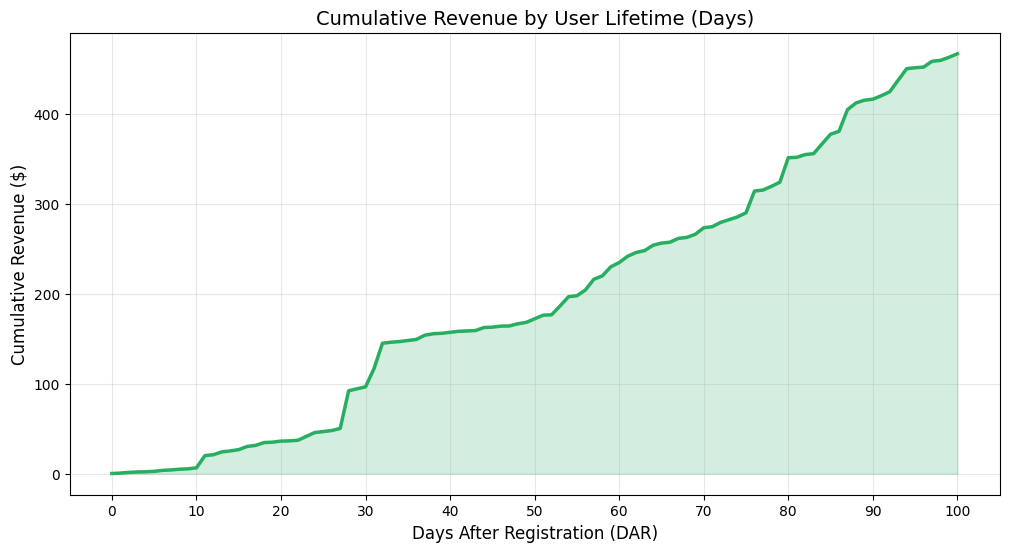

In [29]:
# 7. Построим линейный график кумулятивного дохода
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='dar',
    y='revenue',
    data=result_df,
    color='#27ae60',
    linewidth=2.5
)
plt.fill_between(result_df['dar'], result_df['revenue'], alpha=0.2, color='#27ae60')
plt.title('Cumulative Revenue by User Lifetime (Days)', fontsize=14)
plt.xlabel('Days After Registration (DAR)', fontsize=12)
plt.ylabel('Cumulative Revenue ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 101, 10))
plt.show()

### Выводы по задаче 5
Выручка растет от лайвтайма, продолжаем работать!
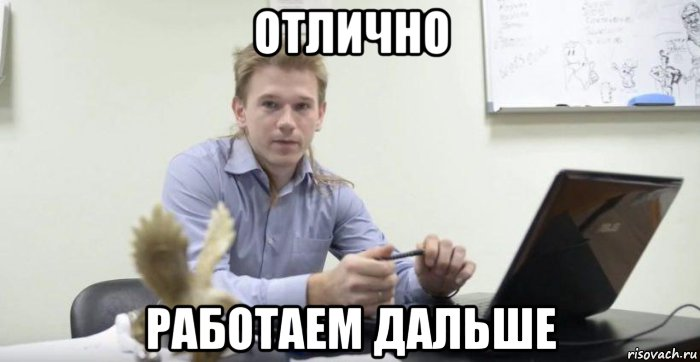


# The END! (: Spasibo za vnimanie